In [1]:
from trace_extract import parse_trace_file
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import pickle as pkl
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
#device = torch.device(2 if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
import time

In [19]:
class RNN_GRU(nn.Module):
    def __init__(self):
        super(RNN_GRU, self).__init__();
        self.gru = nn.GRU(1, 8, 2)
        self.linear = nn.Linear(8, 1)
        self.hidden_state = torch.randn(2, 1, 8, requires_grad=False)
        
    def forward(self, x):#(1, 1, 1) seq_len, batch_size, input_size
        self.hidden_state= self.hidden_state.to(device)
        x, self.hidden_state=self.gru(x, self.hidden_state)#(1, 1, 8)
        self.hidden_state = self.hidden_state.detach()
        x=x.view(-1);
        x=self.linear(x)
        return x        

In [20]:
def asymetric_loss(output, target, alpha=0.75):
    if (output<target):
        loss = 2.0*alpha*((output - target)**2)
    else:
        loss = 2.0*(1-alpha)*((output - target)**2)
    return loss

In [29]:
class RNN_monitor():
    def __init__(self, self_id, monitoring_id, history_size=16):
        self.ita=100000000;
        self.id = self_id
        self.monitoring = monitoring_id
        self.history_size = history_size
        self.arrival_history = deque(maxlen=history_size)
        #self.margin_history = np.zeros(16);
        self.expected_arrival = 0
        self.safety_margin = Variable(torch.tensor([0]).float()).to(device)
        self.rnn_module = RNN_GRU().to(device);
        self.seq_num = -1;
        self.suspect_intervals=[]
        self.U = 0;
        self.lr=1e-4
        self.decay=1e-6
        self.optimizer=optim.SGD(self.rnn_module.parameters(),
                             lr=self.lr,
                             weight_decay=self.decay)
        self.criterion = nn.MSELoss()#asymetric_loss#
        self.loss = 0;
    
    def forward(self, seq_num, arrival_time):
        if (self.seq_num == -1):
            self.seq_num=seq_num
            self.U=arrival_time
            self.arrival_history.append(arrival_time)
            self.expected_arrival = self.U + self.ita;
            x=Variable(torch.tensor([0]).float()).to(device)
            self.safety_margin = self.rnn_module.forward(x.view(1,1,1))
        elif (self.seq_num+1==seq_num):
            start_time=time.time();
            self.rnn_module.zero_grad()
            self.seq_num=seq_num
            if (self.expected_arrival + self.safety_margin.item()*self.ita < arrival_time):
                self.suspect_intervals.append([self.expected_arrival + self.safety_margin, arrival_time])
            self.arrival_history.append(arrival_time)
            #print("append arrival:", time.time()-start_time);start_time=time.time();
            optimal_margin = (arrival_time-self.expected_arrival)/self.ita
            #self.margin_history=np.roll(self.margin_history, -1);
            #self.margin_history[-1]=optimal_margin
            target = Variable(torch.tensor([optimal_margin]).float()).to(device)
            #print("compute optimal:", time.time()-start_time);start_time=time.time();
            self.optimizer.zero_grad()
            self.loss= self.criterion(self.safety_margin, target)
            #print("compute loss:", time.time()-start_time);start_time=time.time();
            self.loss.backward()
            self.optimizer.step()
            #print("back prop:", time.time()-start_time);start_time=time.time();
            input_x = Variable(torch.tensor([optimal_margin]).float()).to(device)            
            self.safety_margin = self.rnn_module.forward(input_x.view(1,1,1))
            #print("estimate next:", time.time()-start_time);start_time=time.time();
            self.cal_expectation()
            
        elif (self.seq_num<seq_num):
            self.seq_num=seq_num
            self.arrival_history.clear();
            self.U=arrival_time
            self.arrival_history.append(arrival_time)
            self.expected_arrival = self.U + self.ita;
    
    def cal_expectation(self):
        if (len(self.arrival_history)<self.history_size):
            k = len(self.arrival_history);
            temp_U = self.arrival_history[-1]/(k)+(k-1)*self.U/(k)
            self.U = temp_U
            self.expected_arrival = self.U + (k+1)/2*self.ita;
        else:
            temp = (self.arrival_history[-1]-self.arrival_history[0])/(self.history_size-1)
            self.expected_arrival += temp
        return self.expected_arrival


In [5]:
in_path = "../raw_data/"
trace_name = "trace%d.log"
cur_file=in_path+trace_name%(1);
arrival_times, c = parse_trace_file(cur_file)
print(c)

2982139


In [30]:
for j in range(4,5):
    error_history=[]
    if (j==1): continue;
    print("monitoring process %d"%(j))
    print("total receive %d"%(len(arrival_times[j])))
    monitor = RNN_monitor(1, j)
    for (k,trace) in enumerate(arrival_times[j]):
        n=trace[0]
        t=trace[1]
        expt=monitor.expected_arrival/1e9
        sft=monitor.safety_margin.item()
        maxt=expt+sft
        error_history.append(t/1e9-maxt)
        if (k%10000==1):
            print("expected and safety margin:", expt, sft)
            print("maximum waiting time", maxt)
            print("actual time", t/1e9)
            print("RNN loss", monitor.loss)
        monitor.forward(n, t)
    print(len(monitor.suspect_intervals))

monitoring process 4
total receive 330815
expected and safety margin: 47816110.4128539 -0.1364865005016327
maximum waiting time 47816110.276367396
actual time 47816110.404046886
RNN loss 0
expected and safety margin: 47817112.60290685 -0.018554773181676865
maximum waiting time 47817112.584352076
actual time 47817112.60255427
RNN loss tensor(0.0003, grad_fn=<MseLossBackward>)
expected and safety margin: 47818115.01034641 -0.0035077938809990883
maximum waiting time 47818115.00683862
actual time 47818115.00330736
RNN loss tensor(0.0075, grad_fn=<MseLossBackward>)
expected and safety margin: 47819117.30286947 -0.004958717152476311
maximum waiting time 47819117.29791075
actual time 47819117.302355714
RNN loss tensor(0.0004, grad_fn=<MseLossBackward>)
expected and safety margin: 47820119.20389098 -0.002833925187587738
maximum waiting time 47820119.201057054
actual time 47820119.203002974
RNN loss tensor(3.4059e-05, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

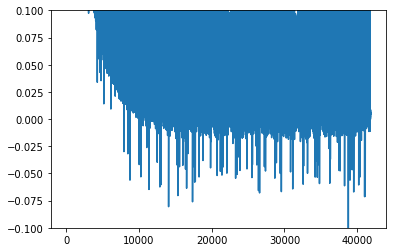

In [31]:
plt.plot(error_history[1:])
plt.ylim(-0.1, 0.1)
plt.show()

In [7]:

f=open("../output_data/RNN_suspect%d_%d.pkl"%(1,j), "wb");
pkl.dump(monitor.suspect_intervals, f)
pkl.dump(arrival_times[j][0], f)
pkl.dump(arrival_times[j][-1], f)
f.close()

RuntimeError: cuda runtime error (46) : all CUDA-capable devices are busy or unavailable at /opt/conda/conda-bld/pytorch_1544174967633/work/torch/csrc/generic/serialization.cpp:15